In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.interpolate import CubicSpline

In [40]:
def get_number_file(filename):
    '''
    Extracts number from image name
    '''
    return int(filename.split('_')[1].split('.')[0])

def display_image(image):
    '''
    Shows single image in RGB format
    '''
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")
    plt.show()

In [41]:
BASE_DIR = '/kaggle/input/drone-images/drone_data' # Change this
images_dir = os.path.join(BASE_DIR, 'crops')
path_map = os.path.join(BASE_DIR, 'global_map.png')

images_names = sorted(os.listdir(images_dir), key=get_number_file) # Sort image names to have consecutive sequence

# Load the general map image
map_img = cv2.imread(path_map)
map_img_rgb = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)

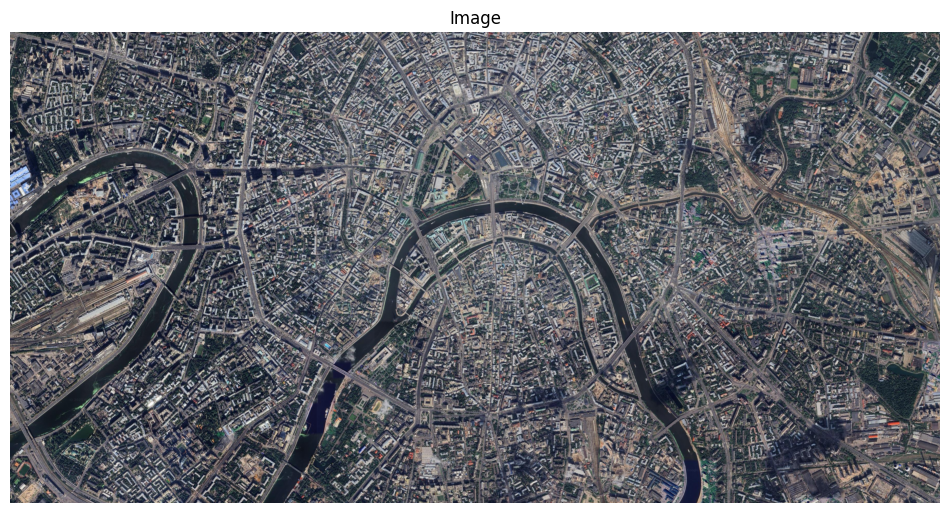

In [42]:
display_image(map_img_rgb) # General map

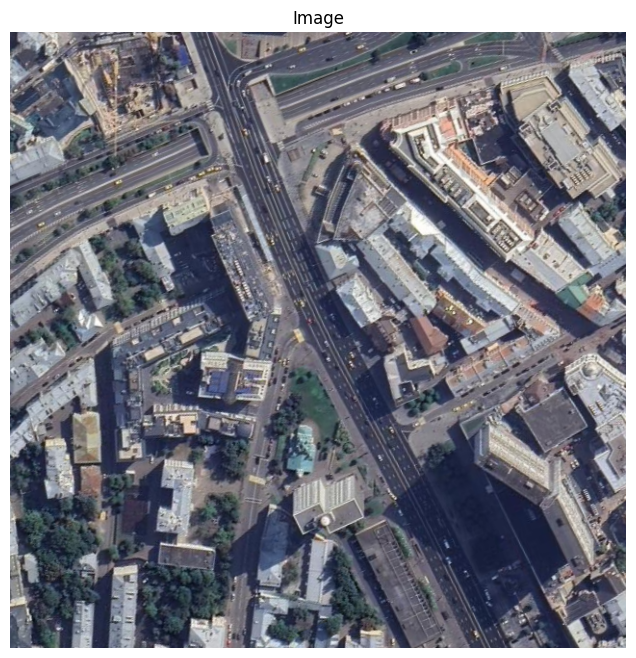

In [43]:
random_image = cv2.cvtColor(cv2.imread(os.path.join(images_dir, images_names[15])), cv2.COLOR_BGR2RGB) # Convert to RGB
display_image(random_image)

### Main code

The keypoints estimation, detection, filtering - all is runing on CPU since for CUDA support there should be additionally installed OpenCV library with CUDA support. So it takes some times to process all images

In [17]:
def detect_and_match_features(map_img, uav_img):
    """
    Detects and matches SIFT features between a reference map image and a drone image
    Returns detected keypoints in drone image, map and good matches
    """
    # grayscale for feature detection
    map_gray = cv2.cvtColor(map_img, cv2.COLOR_BGR2GRAY)
    drone_gray = cv2.cvtColor(uav_img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kp_map, des_map = sift.detectAndCompute(map_gray, None)
    kp_drone, des_drone = sift.detectAndCompute(drone_gray, None)
    
    index_params = dict(algorithm=1, trees=10) # 10 is number of times the tree will be recursively traversed
    search_params = dict(checks=50)  # Higher = more accurate but slower 50 chosen for a good balance
                                     
    # FLANN  matcher for faster and better descriptor matching in case of complex images
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_map, des_drone, k=2)  # Find the 2 nearest matches for each descriptor
    
    # Apply Lowe's ratio test to filter good matches to reject ambiguous matches by comparing distances between the best and second-best matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:  # 0.7 is default ot Lowe's test
            good_matches.append(m)
    
    return kp_map, kp_drone, good_matches

def draw_matches(map_img, drone_img, kp_map, kp_drone, good_matches):
    """
    Draws the feature matches between the map and drone image
    Returns image showing the matches drawn between the two images
    """
    matched_img = cv2.drawMatches(map_img, kp_map, drone_img, kp_drone, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return matched_img

def estimate_homography(kp_map, kp_drone, good_matches):
    """
    Estimates a homography matrix from matched keypoints using RANSAC
    Returns 3x3 homography matrix mapping UAV image points to the map
    """
    points_map = np.array([kp_map[m.queryIdx].pt for m in good_matches], dtype=np.float32)
    points_drone = np.array([kp_drone[m.trainIdx].pt for m in good_matches], dtype=np.float32)
    
    # Estimate homography using RANSAC to reject outliers
    # 5.0 is the reprojection error threshold, lower = stricter but needs more accurate matches
    homography, mask = cv2.findHomography(points_drone, points_map, cv2.RANSAC, 5.0)
    
    return homography

def track_trajectory(images_dir, img_list, map_img):
    """
    Tracks the UAV's trajectory across a sequence of images using feature matching
    and homography estimation
    Returns smoothed drone trajectory as an array of 2D coordinates
    """
    trajectory = []
    for img_name in tqdm(img_list):
        drone_image = cv2.imread(os.path.join(images_dir, img_name))
        
        kp_map, kp_drone, good_matches = detect_and_match_features(map_img, drone_image)
        
        # Minimum 4 matches to compute homography
        if len(good_matches) > 4:
            homography = estimate_homography(kp_map, kp_drone, good_matches)
            
            # Define UAV image corners to be transformed
            h, w = drone_image.shape[:2]
            drone_corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
            
            # Transform drone image corners to map coordinate space
            map_corners = cv2.perspectiveTransform(drone_corners[None, :, :], homography)
            
            # Calculate the center of the drone's position using the average of the projected corners
            center = np.mean(map_corners, axis=1)[0]
            trajectory.append(center)
    
    # Smoothing the trajectory
    trajectory = np.array(trajectory)
    if len(trajectory) > 2:
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        
        # Use cubic spline interpolation to smooth trajectory coordinates
        spline_x = CubicSpline(range(len(x)), x)
        spline_y = CubicSpline(range(len(y)), y)
        
        # Evaluate spline at original index positions
        smooth_trajectory = np.array([(spline_x(i), spline_y(i)) for i in range(len(x))])
    else:
        smooth_trajectory = trajectory
    
    return smooth_trajectory


In [38]:
def visualize_trajectory(map_img, trajectory):
    """
    Visualizes the drone trajectory on the map, drawing the path and marking start and end points.
    Returns map with drawn trajectory.
    """
    map_img_rgb = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)
    overlay = map_img_rgb.copy()

    start_color = (0, 0, 255)       # Blue - start point
    end_color = (255, 0, 0)         # Red - end point
    trajectory_color = (0, 255, 0)  # Green - line of trajectory and points

    for i in range(1, len(trajectory)):
        pt1 = tuple(np.round(trajectory[i - 1]).astype(int))
        pt2 = tuple(np.round(trajectory[i]).astype(int))
        cv2.line(overlay, pt1, pt2, trajectory_color, thickness=6)

    alpha = 0.5
    map_img_rgb = cv2.addWeighted(overlay, alpha, map_img_rgb, 1 - alpha, 0)

    for pt in trajectory:
        pt = tuple(np.round(pt).astype(int))
        cv2.circle(map_img_rgb, pt, radius=8, color=trajectory_color, thickness=-1)

    start_point = tuple(np.round(trajectory[0]).astype(int))
    end_point = tuple(np.round(trajectory[-1]).astype(int))
    cv2.circle(map_img_rgb, start_point, radius=12, color=start_color, thickness=-1)
    cv2.circle(map_img_rgb, end_point, radius=12, color=end_color, thickness=-1)

    plt.figure(figsize=(20, 10))
    plt.imshow(map_img_rgb)
    plt.title("Drone trajectory")
    plt.axis('off')
    plt.show()

    return cv2.cvtColor(map_img_rgb, cv2.COLOR_RGB2BGR)

In [21]:
map_img = cv2.imread(path_map)
map_img_rgb = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)
trajectory = track_trajectory(images_dir, images_names, map_img)

100%|██████████| 50/50 [08:35<00:00, 10.30s/it]


In [37]:
print(f'Number of trajectory points: {len(trajectory)}')

Number of trajectory points: 50


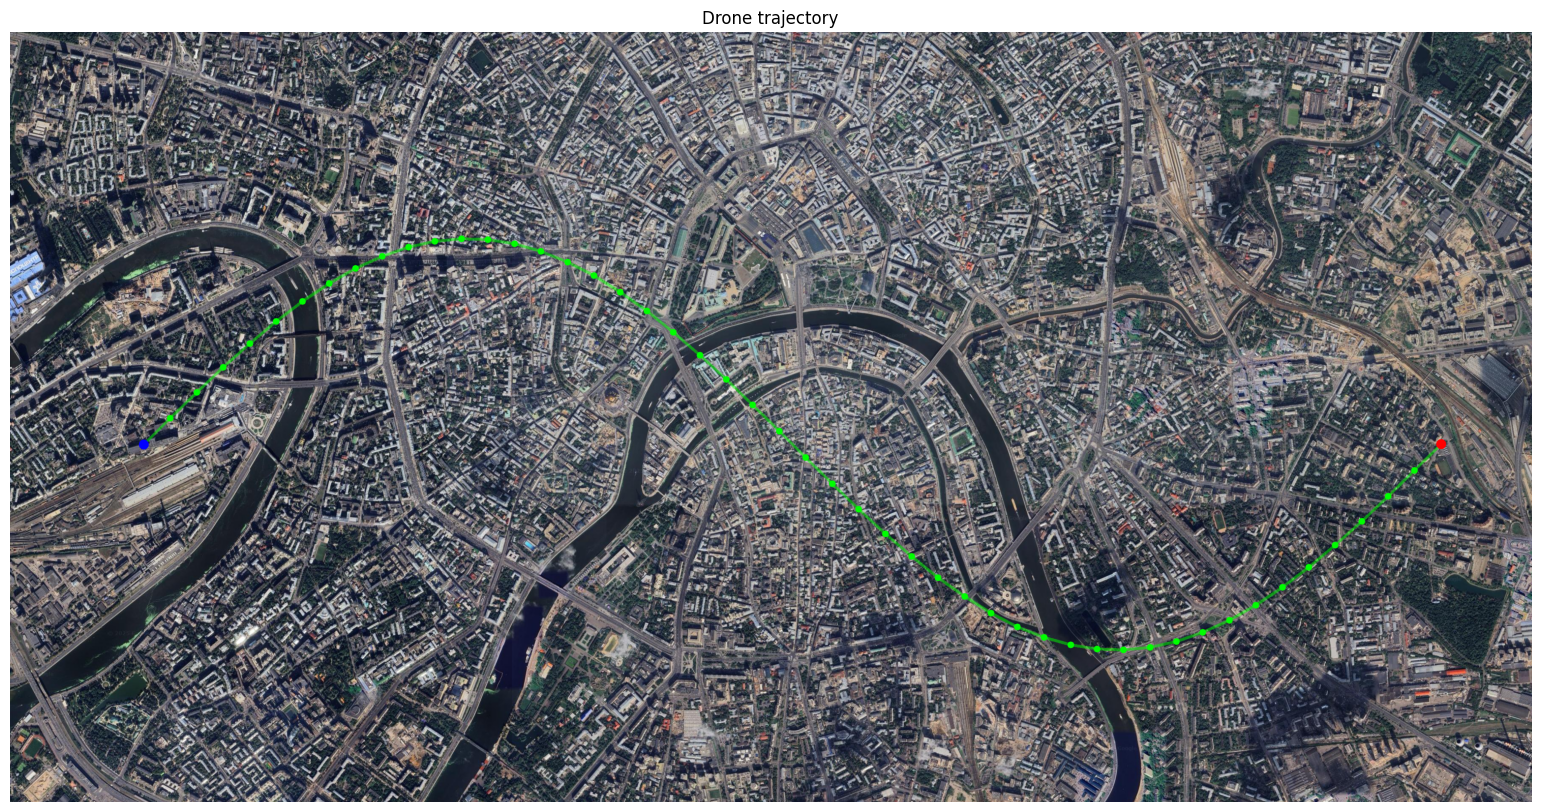

True

In [39]:
path_to_save = 'trajectory_map.png'
trajectory_map = visualize_trajectory(map_img, trajectory)
# cv2.imwrite(path_to_save, trajectory_map)

Blue point is start position and red point is finish